# TD3 : VGG voit-il les lémuriens ?

Dans ce TD nous explorerons les couches de convolutions de VGG. 

In [4]:
%%capture
import torch
import torchvision
vgg16_model = torchvision.models.vgg16(pretrained=True)

# Nous n'allons pas entrainer de modèle dans ce TD. Voilà pourquoi il est important de mettre votre modèle en
# mode évaluation
vgg16_model.eval()

Regardons le contenu de vgg16_model

In [25]:
print(vgg16_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Une image traitée par VGG 16 passera par dans l'ordre par:
- 1) vgg16_model.features : ces couches servent à calculer les descripteurs de l'image
- 2) vgg16_model.avgpool : cette couche réduit la taille des descripteurs avant la classification
- 3) vgg16_model.classifier : il s'agit de la partie classification en temps que telle

Vous remarquerez en regardant le contenu de vgg16_model.classifier que ce dernier possède 3 couches "Linear" en pytorch une couche "Linear" est une couche entièrement connectée.

Nous ne nous intéresserons aujourd'hui qu'à vgg16_model.features.

## vgg16_model.features

Le module Sequential applique dans l'ordre les différent modules qui le compose. 

Par exemple:

Sequential(

    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    
)
    
Est un réseau de neurones qui applique dans l'ordre: une convolution, une fonction d'activation ReLU, une autre convolution et encore un ReLU.

La fonction ReLU est définie ainsi: ReLU(x) = max(x, 0).

## Exercice 1:

Combien de canaux doit avoir l'image d'entrée donnée à vgg16_models ? Combien de canaux a l'image de sortie de la couche numéro 14 de vgg16_model.features ?

vgg16_model.features contient aussi des couches dites "MaxPool2d". MaxPool2d ce n'est pas vraiment une convolution mais presque. MaxPool2d réduit la taille de l'image d'entrée en remplaçant chaque fenêtre de l'image de taille choisie k par le maximum des éléments repérés au sein de cette fenêtre.

Plus précisément, quand un Maxpool2d de kernel_size k et de stride s est appliqué sur un batch d'images X de dimension $(N, C, sH, sL)$, alors sa sortie est un batch d'images Y de taille $(N, C, H, L)$ tel que:

\begin{equation*}
\text{maxpool2d}(X)(n, c, h, l) = \max_{0 \leq \bar{p} < k, 0 \leq \bar{q} < k }X(n, c, h \times s + \bar{p}, l \times s + \bar{q})
\end{equation*}

In [28]:
# Testons MaxPool2d
maxPool = torch.nn.MaxPool2d(kernel_size=2, stride=2)

x = torch.randn(2, 2, 4, 2)
y = maxPool(x)
print(y.size())

torch.Size([2, 2, 2, 1])


In [ ]:
print(x)
print(y)

## Exercice 2:
Comme dans la partie 0 du TD, nous allons devoir récupérer quelques fonctions pré-définies

In [1]:
from tools import load_image_in_vgg_format, show_images_from_path_list, show_batch

In [7]:
def get_nn_sequential_output(input_batch, sequence_model, n_layer):
    r"""
    Calcule la sortie d'une couche spécifique d'un modèle
    Arguments:
       input_image (torch.tensor): notre image d'entrée au format N x C x L x H
       sequence_model (torch.nn.Sequential): le modèle à appliquer. 
                                             Ce modèle doit se présenter sous la forme d'une séquence de modules.
       n_layer (int): index de la sortie que l'on souhaite récupérer
    Renvoie:
       l'image de sortie de la couche n_layer de sequence_model
    """

    # Notre image d'entrée a un format N x C x H x L
    x = input_batch
    for i in range(n_layer+1):
        x = sequence_model[i](x)

    # Notre image de sortie a à présent un format
    # N x C_sortie x H_sortie x L_sortie
    return x

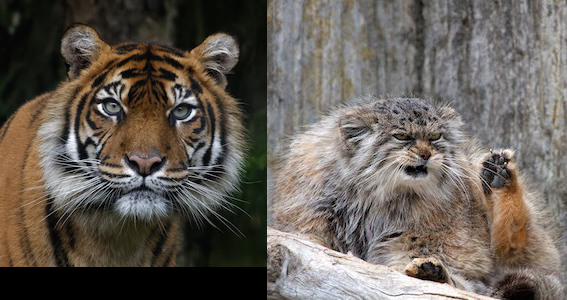

In [5]:
# Testons un peu cette fonction
# 1) Chargeons des images

show_images_from_path_list(['isha.jpg', 'manul.jpg'])
image_isha = load_image_in_vgg_format('isha.jpg')
image_manul = load_image_in_vgg_format('manul.jpg')

In [17]:
# 2 Lançons le modèle
batch_data = torch.cat([image_isha, image_manul], dim=0)
output_1 = get_nn_sequential_output(batch_data, vgg16_model.features, 1)

In [18]:
#L'image de sortie a 128 canaux
print(output_1.size())

torch.Size([2, 64, 224, 224])


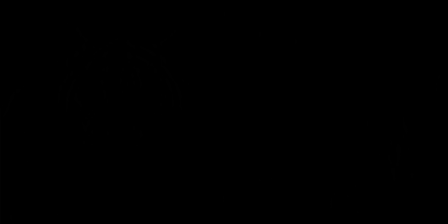

In [19]:
# Affichons à présent l'image correspondant au canal 0 du batch
show_batch(output_1[:, 0])

Comme vous pouvez le constater, le résultat n'est pas très lisible. Pour changer ça définisser 
une fonction normalize_min_max, qui étant donné un tensor X de forme arbitraire lui applique une transformation
affine qui place sa plus petite valeur à zéro et sa plus grande valeur à 1.

In [20]:
def normalize_min_max(input_batch):
    r"""
    Applique une transformation affine au tensor input_batch de manière à ce que ses valeurs soient
    comprises entre 0 et 1
    """
    return output

Testez ensuite la fonction avec le code suivant

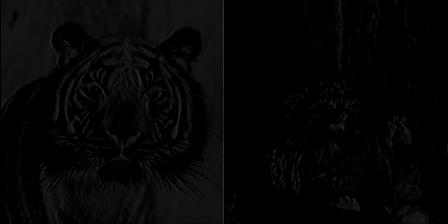

In [21]:
def normalize_min_max(input_batch):
    return (input_batch - input_batch.min()) / (input_batch.max() - input_batch.min())
# Redimensionne les valeurs de output_8 dans [0,1]
normalized_output = normalize_min_max(output_1)
    
# Applique un facteur 255 de manière à avoir des valeurs entre 0 et 255
normalized_output = 255 * normalized_output

# Affiche l'image correspondant au canal désiré. Dans notre cas nous affichons le canal 0.
show_batch(normalized_output[:, 10])


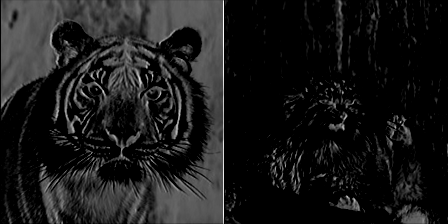

In [22]:
# L'image rendue est toujours assez sombre: c'est normal la plupart des neurones ne sont en réalité que 
# peu ou pas activés. Pour un rendu plus lisible, vous pouvez augmenter le contraste de l'image en y appliquant
# un facteur multiplicatif f

# Dans les couches les plus élevées il arrive qu'aucun des neurones d'un canal entier ne soit activé.
# Pour pouvoir percevoir la distinction entre les canaux porteurs d'informations sur l'image et les autres
# il est nécessaire d'utiliser le même facteur multiplicatif pour comparer l'activité de deux canaux différents
normalized_output = 5 * 255 * normalize_min_max(output_1)
show_batch(normalized_output[:, 10])

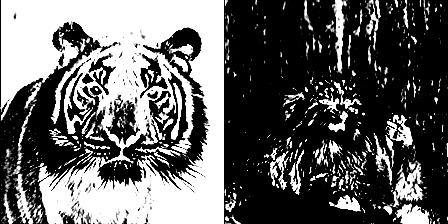

In [24]:
# Attention cependant, un facteur trop élevé saturera l'image.
normalized_output = 50 * 255 * normalize_min_max(output_1)
show_batch(normalized_output[:, 10])

N'hésitez pas à jouer avec ce script pour visualiser les différents canaux des différentes couches de vgg16 !

## Exercice 3 : lemur breafeast club

Dans le dossier team_lemur vous trouverez une série d'images. Effectuez les tâches suivantes:

1) Avec show_images_from_path_list affichez les photos d'origine.

2) Chargez toutes les images dans un même batch

3) Appliquez get_nn_sequential_output pour obtenir les résultats de la 29eme couche de vgg16_model.features

4) Visualisez les images correspondants au 121eme canal du vecteur sortant. Quel est le motif détecté au niveau de ce canal ?

In [ ]:
# Votre code ici
# À vous de jouer !